In [4]:
# Mounting Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
# Importing relevant libraries
import numpy as np
import pandas as pd
import torch
import tensorflow as tf
import keras
import seaborn as sns
import matplotlib.pyplot as plt
from keras.datasets import mnist

from sklearn import metrics
from tqdm.auto import tqdm
import pprint

In [8]:
from torchvision import datasets
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader
from torch import optim
import torch.nn as nn
from torch.autograd import Variable

In [9]:
import time

In [10]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using', device)

Using cpu


# Data Loading

## From Keras

In [8]:
def loadMNIST(val_samples=10000, return_images=False, is_val_split=False, seed_value=0):
    '''
    ################
    Function which returns a dictionary containing the shuffled version of the MNIST dataset.
    Arguments:
    val_samples     [int]   Number of validation samples to take out of the training set of 60K samples     (default: 10K)
    return_images   [bool]  Whether we need to return images            (default: False)
                                True: returns images
                                False: returns flattened vectors
    is_val_split    [bool]  Whether validation split needs to be done   (default: False)
                                True: returns train(60K-val_samples), validation(val_samples) and test(10K)
                                False: returns train(60K) and test(10K)
    seed            [int]   Seed value for the numpy random shuffling   (default: 0)
    ########
    Return:
    Dictionary containing the numpy arrays corresponding to train, test and val(if is_val_split==True)
                    dict:   train:  X
                                    y
                            test:   X
                                    y
                            val:    X           (if is_val_split == True)
                                    y           (if is_val_split == True)
    ################
    '''

    # Loading MNIST data onto numpy arrays
    (x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

    # Shuffling data
    np.random.seed(seed_value)
    train_shuffler = np.random.permutation(60000)
    x_train, y_train = x_train[train_shuffler], y_train[train_shuffler]
    test_shuffler = np.random.permutation(10000)
    x_test, y_test = x_test[test_shuffler], y_test[test_shuffler]

    # Normalizing the input data
    x_train = np.array(x_train/255.0, dtype='float32')
    x_test = np.array(x_test/255.0, dtype='float32')

    ## Splitting data appropriately
    # Number of training samples 
    train_samples = 60000 - val_samples

    if is_val_split == True:
        # Splitting the train set into the new train and val sets
        x_train, x_val = x_train[:train_samples], x_train[train_samples:]
        y_train, y_val = y_train[:train_samples], y_train[train_samples:]

        # Flattening the 28x28 images into vectors and then returning
        if (return_images==False):
            return {
                'train':{
                    'X': x_train.reshape([train_samples, 784]),
                    'Y': y_train.reshape([train_samples])
                },
                'val':{
                    'X': x_val.reshape([val_samples, 784]),
                    'Y': y_val.reshape([val_samples])
                },
                'test':{
                    'X': x_test.reshape([10000, 784]),
                    'Y': y_test.reshape([10000])
                }
            }
        # Returning the 28x28 images as is
        else :
            return {
                'train':{
                    'X': x_train,
                    'Y': y_train
                },
                'val':{
                    'X': x_val,
                    'Y': y_val
                },
                'test':{
                    'X': x_test,
                    'Y': y_test
                }
            }
    # Training set is not split
    else:
        # Flattening the images and then returning
        if (return_images==False):
            return {
                'train':{
                    'X': x_train.reshape([60000, 784]),
                    'Y': y_train.reshape([60000])
                },
                'test':{
                    'X': x_test.reshape([10000, 784]),
                    'Y': y_test.reshape([10000])
                }
            }
        # Returning the images as is
        else :
            return {
                'train':{
                    'X': x_train,
                    'Y': y_train
                },
                'test':{
                    'X': x_test,
                    'Y': y_test
                }
            }


In [ ]:
# Loading data as flattened vectors with no validation set
data = loadMNIST()

## From PyTorch

In [11]:
train_data = datasets.MNIST(
    root = 'data',
    train = True,                         
    transform = ToTensor(), 
    download = True         
)
test_data = datasets.MNIST(
    root = 'data', 
    train = False, 
    transform = ToTensor()
)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [12]:
print(train_data, '\n')
print(test_data)

Dataset MNIST
    Number of datapoints: 60000
    Root location: data
    Split: Train
    StandardTransform
Transform: ToTensor() 

Dataset MNIST
    Number of datapoints: 10000
    Root location: data
    Split: Test
    StandardTransform
Transform: ToTensor()


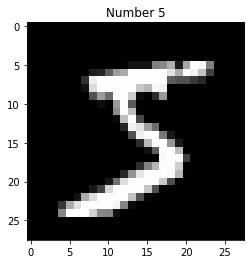

In [42]:
# Plotting one data point from MNIST
direc = './drive/MyDrive/Semester_7/Advanced_Signal_Processing/A2_CNN/CNN_pics/'
prefix = direc + 'dset_'
plt.imshow(train_data.data[0], cmap='gray')
plt.title('Number %i' % train_data.targets[0])
plt.savefig(prefix + '1point.png', bbox_inches='tight')
plt.show()

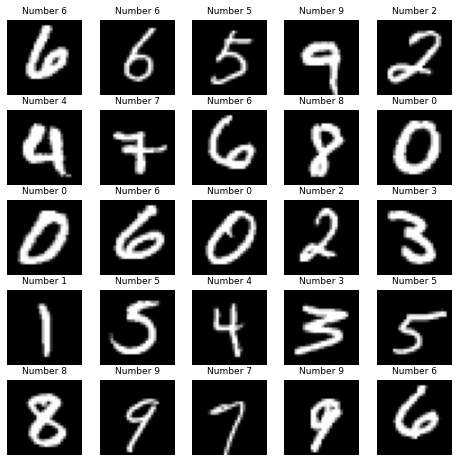

In [45]:
# Plotting 25 random data points from the dataset to get an idea of the dataset
direc = './drive/MyDrive/Semester_7/Advanced_Signal_Processing/A2_CNN/CNN_pics/'
prefix = direc + 'dset_'
figure = plt.figure(figsize=(8, 8))
cols, rows = 5, 5
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(train_data), size=(1,)).item()
    img, label = train_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title('Number {}'.format(label), fontsize=9)
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.savefig(prefix + '25point.png',bbox_inches='tight')
plt.show()

# Baseline Model

In [46]:
# Class defining the CNN model
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Sequential(         
            nn.Conv2d(
                in_channels=1,              
                out_channels=32,            
                kernel_size=3,              
                stride=1,                   
                padding=1,                  
            ),                              
            nn.ReLU(),
        )
        self.conv2 = nn.Sequential(         
            nn.Conv2d(
                in_channels=32,              
                out_channels=32,            
                kernel_size=3,              
                stride=1,                   
                padding=1,                  
            ),                              
            nn.ReLU(),
        )
        self.mp = nn.Sequential(
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(32*7*7, 500), 
            nn.ReLU(),
            nn.Linear(500, 10)
        )
        
    def forward(self, x):
        values = {}
        values['c1'] = self.conv1(x)
        values['c1_mp'] = self.mp(values['c1'])
        values['c2'] = self.conv2(values['c1_mp'])
        values['c2_mp'] = self.mp(values['c2'])
        values['logits'] = self.fc(values['c2_mp'])
        values['fc'] = nn.Softmax(dim=1)(values['logits'])

        return {
            'values': values,
            'in': x,
            'preds': torch.argmax(values['fc'], dim=1)
        }


In [47]:
model = CNN()
print(model)

CNN(
  (conv1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
  )
  (conv2): Sequential(
    (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
  )
  (mp): Sequential(
    (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=1568, out_features=500, bias=True)
    (2): ReLU()
    (3): Linear(in_features=500, out_features=10, bias=True)
  )
)


## Training The Model

In [48]:
# Train has 600 batches of size 100. Test is just 1 batch of 10K as we only use it for testing.
loaders = {
    'train' : torch.utils.data.DataLoader(train_data, 
                                          batch_size=100, 
                                          shuffle=True, 
                                          num_workers=1),
    
    'test'  : torch.utils.data.DataLoader(test_data, 
                                          batch_size=10000, 
                                          shuffle=True, 
                                          num_workers=1),
}

In [49]:
def train_loop(loaders, model, loss_fn, optimizer, interval=40):
    '''
    Function to train the model and log required information
    Arguments:
    loaders                 dict containing DataLoader objects for the data
    model                   The neural network we want to train
    loss_fn                 The loss function we are trying to minimize
    optimizer               Optimizer that we will use
    interval                Interval between logging of loss & calculating test metrics [default: 40]
    Returns:    Dict containing lists of training losses and test losses & accuracies.
    '''
    dataloader = loaders['train']
    size = len(dataloader.dataset)
    losses = []
    losses_test = []
    acc_test = []

    for batch, (X, y) in enumerate(dataloader):
        # Compute prediction and loss
        pred = model(X)['values']['fc']
        loss = loss_fn(pred, y)
        losses.append(loss.item())

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % interval == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"Loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
            temp1 = test_loop(loaders, model, loss_fn)
            losses_test.append(temp1['loss'])
            acc_test.append(temp1['acc'])
        
    return {
        'losses': losses,
        'losses_test': losses_test,
        'acc_test': acc_test
    }


def test_loop(loaders, model, loss_fn):
    '''
    Function to calculate loss and accuracy of the model on the test set.
    Arguments:
    loaders                 dict containing DataLoader objects for the data
    model                   The neural network we want to test
    loss_fn                 The loss function we are trying to minimize in training
    Returns:    Dict containing loss and accuracy of the model on the test dataset
    '''
    dataloader = loaders['test']
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    with torch.no_grad():
        for X, y in dataloader:
            temp = model(X)
            test_loss += loss_fn(temp['values']['fc'], y).item()
            correct += (temp['preds'] == y).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    print(f"Test Metrics: \nAccuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

    return {
        'loss': test_loss,
        'acc': 100*correct
    }

In [50]:
# Cross Entropy Loss
loss_fn = nn.CrossEntropyLoss()   
print('Loss:', loss_fn)

# Adam optimizer
optimizer = optim.Adam(model.parameters())
print('\nOptimizer:', optimizer)

Loss: CrossEntropyLoss()

Optimizer: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.001
    weight_decay: 0
)


In [51]:
# These many epochs seem to be enough for saturation.
num_epochs = 6

In [52]:
# Warming up the compute for optimal time measurement
start = time.time()
temp1 = np.random.rand(3000, 2000)
temp2 = np.random.rand(2000, 1000)
temp1 = temp1@temp2
end = time.time()

# Measuring time taken for the training process
losses = []
losses_test = []
acc_test = []
interval = 75
start = time.time()
for i in range(num_epochs):
    print(f"Epoch {i+1}\n-------------------------------")
    
    # Training the network for this epoch
    temp = train_loop(loaders, model, loss_fn, optimizer, interval)
    losses += temp['losses']
    losses_test += temp['losses_test']
    acc_test += temp['acc_test']

temp = test_loop(loaders, model, loss_fn)
losses_test.append(temp['loss'])
acc_test.append(temp['acc'])
end = time.time()
print('Time taken for the training:', end-start, 'seconds')


Epoch 1
-------------------------------
Loss: 2.302546  [    0/60000]
Test Metrics: 
Accuracy: 19.2%, Avg loss: 2.299281 

Loss: 1.928272  [ 7500/60000]
Test Metrics: 
Accuracy: 56.5%, Avg loss: 1.894936 

Loss: 1.724282  [15000/60000]
Test Metrics: 
Accuracy: 83.5%, Avg loss: 1.629416 

Loss: 1.608260  [22500/60000]
Test Metrics: 
Accuracy: 86.4%, Avg loss: 1.600590 

Loss: 1.581369  [30000/60000]
Test Metrics: 
Accuracy: 87.0%, Avg loss: 1.594911 

Loss: 1.587154  [37500/60000]
Test Metrics: 
Accuracy: 87.9%, Avg loss: 1.583935 

Loss: 1.572279  [45000/60000]
Test Metrics: 
Accuracy: 88.3%, Avg loss: 1.580442 

Loss: 1.605780  [52500/60000]
Test Metrics: 
Accuracy: 88.4%, Avg loss: 1.578841 

Epoch 2
-------------------------------
Loss: 1.595595  [    0/60000]
Test Metrics: 
Accuracy: 88.7%, Avg loss: 1.574710 

Loss: 1.548347  [ 7500/60000]
Test Metrics: 
Accuracy: 89.0%, Avg loss: 1.570807 

Loss: 1.572637  [15000/60000]
Test Metrics: 
Accuracy: 89.1%, Avg loss: 1.570729 

Loss: 1

In [53]:
# Accuracy at the end of training on the test dataset
print('Test accuracy after training = {0:.5f}%'.format(acc_test[-1]))

Test accuracy after training = 98.94000%


In [54]:
# Saving the trained network
direc = './drive/MyDrive/Semester_7/Advanced_Signal_Processing/A2_CNN/'
torch.save(model, direc+'baseline_model.pth')

## Plotting

In [55]:
def plotGraphs(losses, losses_test, acc_test, interval, prefix=''):
    '''
    Function to do all the relevant plotting of loss, accuracy vs iterations
    Arguments:
    losses          List containing loss on the training set every iteration
    losses_test     List containing loss on the test set every 'interval' iterations
    acc_test        Accuracy of prediction on the test set every 'interval' iterations    
    interval        Number of iterations between test set evaluations during training
    prefix          Prefix to be added to plot names when saving     (default: '')
    '''
    # Number of iterations carried out during training
    num_iters = len(losses)

    plt.figure()
    plt.plot(np.arange(num_iters), losses)
    plt.grid()
    plt.xlabel('Iterations')
    plt.ylabel('Loss')
    plt.title('Train Loss Plot')
    plt.savefig(prefix + '_train_loss.png',bbox_inches='tight')
    # wandb.log({"Loss v iter": plt})
    plt.show()

    plt.figure()
    plt.plot(list(np.arange(1, num_iters-1, interval)) + [num_iters], acc_test)
    plt.grid()
    plt.xlabel('Iterations')
    plt.ylabel('Accuracy')
    plt.title('Test Accuracy Plot')
    plt.savefig(prefix + '_test_acc.png',bbox_inches='tight')
    # wandb.log({"Accuracy v iter(test)": plt})
    plt.show()

    plt.figure()
    plt.plot(list(np.arange(1, num_iters-1, interval)) + [num_iters], losses_test)
    plt.grid()
    plt.xlabel('Iterations')
    plt.ylabel('Loss')
    plt.title('Test Loss Plot')
    plt.savefig(prefix + '_test_loss.png',bbox_inches='tight')
    # wandb.log({"Loss v iter(test)": plt})
    plt.show()


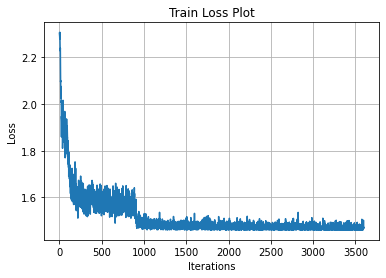

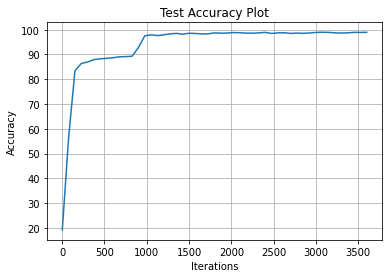

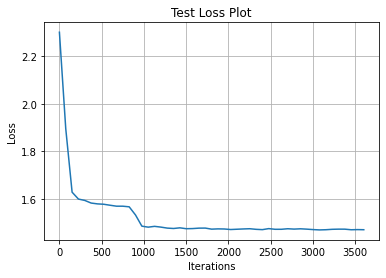

In [56]:
# Plotting of training and test metrics
direc = './drive/MyDrive/Semester_7/Advanced_Signal_Processing/A2_CNN/CNN_pics/'
prefix = direc + 'baseline'
plotGraphs(losses, losses_test, acc_test, interval, prefix)

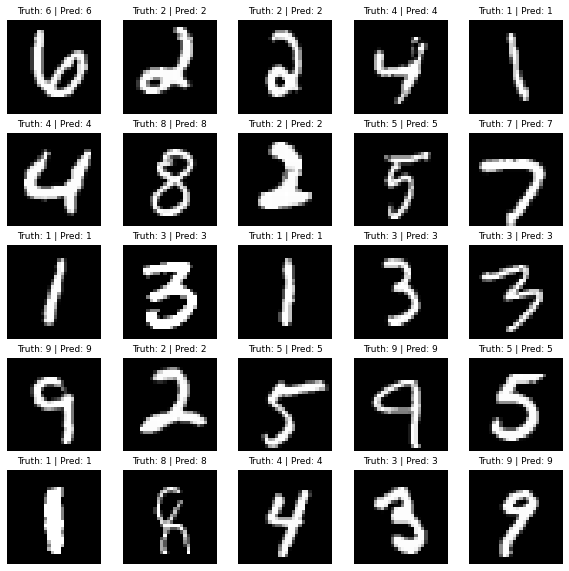

In [57]:
dataloader = loaders['test']
direc = './drive/MyDrive/Semester_7/Advanced_Signal_Processing/A2_CNN/CNN_pics/'
prefix = direc + 'baseline'

with torch.no_grad():
    for X, y in dataloader:
        temp = model(X)
    
    figure = plt.figure(figsize=(10, 10))
    cols, rows = 5, 5
    for i in range(1, cols * rows + 1):
        sample_idx = torch.randint(5000, size=(1,)).item()
        img, label = X[sample_idx], y[sample_idx]
        figure.add_subplot(rows, cols, i)
        plt.title('Truth: {} | Pred: {}'.format(label, temp['preds'][sample_idx]), fontsize=9)
        plt.axis("off")
        plt.imshow(img.squeeze(), cmap="gray")
    plt.savefig(prefix + '_samples.png',bbox_inches='tight')
    plt.show()


## BatchNormalization

In [60]:
# Class to define CNN with Batch Normalisation
class CNN_bn(nn.Module):
    def __init__(self):
        super(CNN_bn, self).__init__()
        self.conv1 = nn.Sequential(         
            nn.Conv2d(
                in_channels=1,              
                out_channels=32,            
                kernel_size=3,              
                stride=1,                   
                padding=1,                  
            ),
            nn.BatchNorm2d(32),
            nn.ReLU(),                      
        )
        self.conv2 = nn.Sequential(         
            nn.Conv2d(
                in_channels=32,              
                out_channels=32,            
                kernel_size=3,              
                stride=1,                   
                padding=1,                  
            ),
            nn.BatchNorm2d(32),
            nn.ReLU(),                      
        )
        self.mp = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(32*7*7, 500),
            nn.BatchNorm1d(500),
            nn.ReLU(),
            nn.Linear(500, 10)
        )
        
    def forward(self, x):
        values = {}
        values['c1'] = self.conv1(x)
        values['c1_mp'] = self.mp(values['c1'])
        values['c2'] = self.conv2(values['c1_mp'])
        values['c2_mp'] = self.mp(values['c2'])
        values['logits'] = self.fc(values['c2_mp'])
        values['fc'] = nn.Softmax(dim=1)(values['logits'])

        return {
            'values': values,
            'in': x,
            'preds': torch.argmax(values['fc'], dim=1)
        }


In [61]:
model_bn = CNN_bn()
print(model_bn)

CNN_bn(
  (conv1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (conv2): Sequential(
    (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (mp): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=1568, out_features=500, bias=True)
    (2): BatchNorm1d(500, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): ReLU()
    (4): Linear(in_features=500, out_features=10, bias=True)
  )
)


In [62]:
# Cross Entropy Loss
loss_fn = nn.CrossEntropyLoss()   
print('Loss:', loss_fn)

# Adam optimizer
optimizer = optim.Adam(model_bn.parameters())
print('\nOptimizer:', optimizer)

Loss: CrossEntropyLoss()

Optimizer: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.001
    weight_decay: 0
)


In [64]:
# These many epochs seem to be enough for saturation.
num_epochs = 6

In [65]:
# Warming up the compute for optimal time measurement
start = time.time()
temp1 = np.random.rand(3000, 2000)
temp2 = np.random.rand(2000, 1000)
temp1 = temp1@temp2
end = time.time()

# Measuring time taken for the training process
losses_bn = []
losses_test_bn = []
acc_test_bn = []
interval = 75
start = time.time()
for i in range(num_epochs):
    print(f"Epoch {i+1}\n-------------------------------")
    
    # Training the network for this epoch
    temp = train_loop(loaders, model_bn, loss_fn, optimizer, interval)
    losses_bn += temp['losses']
    losses_test_bn += temp['losses_test']
    acc_test_bn += temp['acc_test']

temp = test_loop(loaders, model_bn, loss_fn)
losses_test_bn.append(temp['loss'])
acc_test_bn.append(temp['acc'])
end = time.time()
print('Time taken for the training:', end-start, 'seconds')


Epoch 1
-------------------------------
Loss: 2.305922  [    0/60000]
Test Metrics: 
Accuracy: 57.8%, Avg loss: 2.093282 

Loss: 1.512531  [ 7500/60000]
Test Metrics: 
Accuracy: 97.5%, Avg loss: 1.499233 

Loss: 1.510607  [15000/60000]
Test Metrics: 
Accuracy: 97.7%, Avg loss: 1.491535 

Loss: 1.485502  [22500/60000]
Test Metrics: 
Accuracy: 98.3%, Avg loss: 1.482367 

Loss: 1.480691  [30000/60000]
Test Metrics: 
Accuracy: 98.2%, Avg loss: 1.482583 

Loss: 1.475827  [37500/60000]
Test Metrics: 
Accuracy: 98.6%, Avg loss: 1.479259 

Loss: 1.463857  [45000/60000]
Test Metrics: 
Accuracy: 98.5%, Avg loss: 1.479732 

Loss: 1.489716  [52500/60000]
Test Metrics: 
Accuracy: 98.6%, Avg loss: 1.478195 

Epoch 2
-------------------------------
Loss: 1.469033  [    0/60000]
Test Metrics: 
Accuracy: 98.7%, Avg loss: 1.476850 

Loss: 1.494427  [ 7500/60000]
Test Metrics: 
Accuracy: 98.8%, Avg loss: 1.475994 

Loss: 1.462087  [15000/60000]
Test Metrics: 
Accuracy: 98.7%, Avg loss: 1.475053 

Loss: 1

In [66]:
# Accuracy at the end of training on the test dataset
print('Test accuracy after training = {0:.5f}%'.format(acc_test_bn[-1]))

Test accuracy after training = 99.18000%


In [67]:
# Saving the trained network
direc = './drive/MyDrive/Semester_7/Advanced_Signal_Processing/A2_CNN/'
torch.save(model_bn, direc+'baseline_model_bn.pth')

# Visualizing the Network

## Filters

In [68]:
direc = './drive/MyDrive/Semester_7/Advanced_Signal_Processing/A2_CNN/'
model = torch.load(direc+'baseline_model.pth')

In [69]:
for name, param in model.named_parameters():
    print('name: ', name)
    print(type(param))
    print('param.shape: ', param.shape)
    print('param.requires_grad: ', param.requires_grad)
    print('=====')

name:  conv1.0.weight
<class 'torch.nn.parameter.Parameter'>
param.shape:  torch.Size([32, 1, 3, 3])
param.requires_grad:  True
=====
name:  conv1.0.bias
<class 'torch.nn.parameter.Parameter'>
param.shape:  torch.Size([32])
param.requires_grad:  True
=====
name:  conv2.0.weight
<class 'torch.nn.parameter.Parameter'>
param.shape:  torch.Size([32, 32, 3, 3])
param.requires_grad:  True
=====
name:  conv2.0.bias
<class 'torch.nn.parameter.Parameter'>
param.shape:  torch.Size([32])
param.requires_grad:  True
=====
name:  fc.1.weight
<class 'torch.nn.parameter.Parameter'>
param.shape:  torch.Size([500, 1568])
param.requires_grad:  True
=====
name:  fc.1.bias
<class 'torch.nn.parameter.Parameter'>
param.shape:  torch.Size([500])
param.requires_grad:  True
=====
name:  fc.3.weight
<class 'torch.nn.parameter.Parameter'>
param.shape:  torch.Size([10, 500])
param.requires_grad:  True
=====
name:  fc.3.bias
<class 'torch.nn.parameter.Parameter'>
param.shape:  torch.Size([10])
param.requires_grad: 

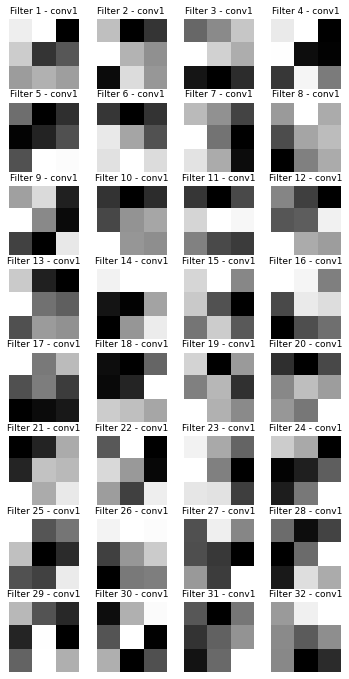

In [70]:
# Plotting all conv1 2d filters
direc = './drive/MyDrive/Semester_7/Advanced_Signal_Processing/A2_CNN/CNN_pics/'
prefix = direc + 'filters_'
figure = plt.figure(figsize=(6, 12))
cols, rows = 4, 8
for i in range(1, cols * rows + 1):
    img = model.state_dict()['conv1.0.weight'][i-1,0,:,:]
    figure.add_subplot(rows, cols, i)
    plt.title('Filter {} - conv1'.format(i), fontsize=9)
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.savefig(prefix + 'c1.png',bbox_inches='tight')
plt.show()

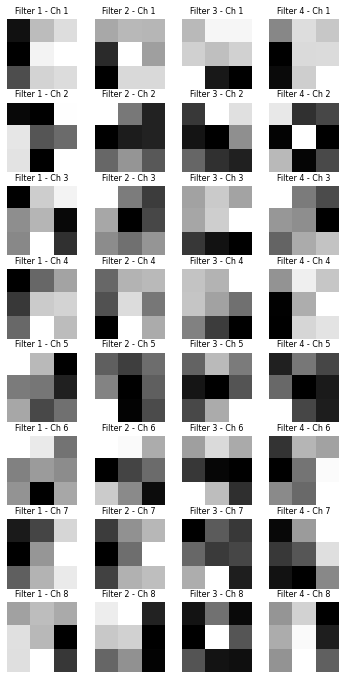

In [71]:
# Plotting 8 channels of 4 conv2 2d filters
direc = './drive/MyDrive/Semester_7/Advanced_Signal_Processing/A2_CNN/CNN_pics/'
prefix = direc + 'filters_'
figure = plt.figure(figsize=(6, 12))
cols, rows = 4, 8
for i in range(1, rows+1):
    for j in range(1, cols+1):
        img = model.state_dict()['conv2.0.weight'][j-1,i-1,:,:]
        figure.add_subplot(rows, cols, (i-1)*cols+j)
        plt.title('Filter {1} - Ch {0}'.format(i, j), fontsize=8)
        plt.axis("off")
        plt.imshow(img.squeeze(), cmap="gray")
plt.savefig(prefix + 'c2.png',bbox_inches='tight')
plt.show()

## Activations

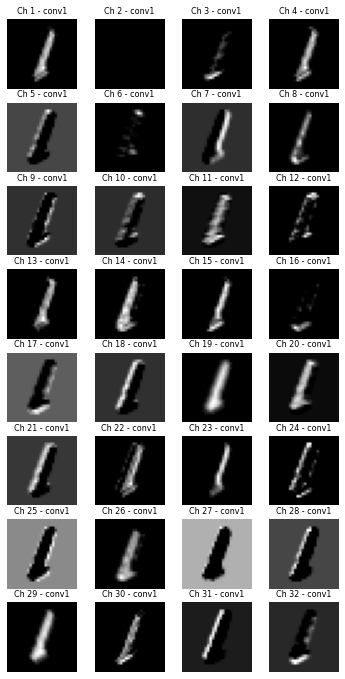

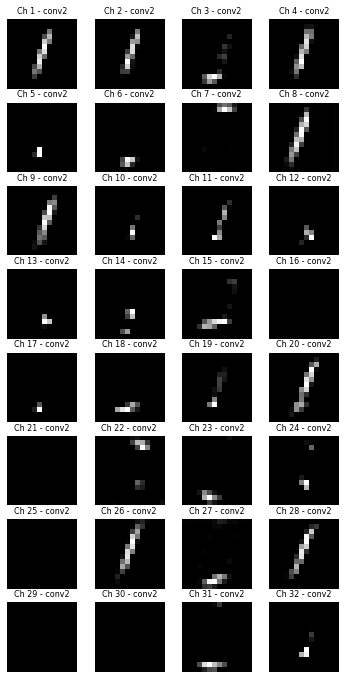

In [72]:
# Plotting activation of conv1 and conv2
dataloader = loaders['test']
direc = './drive/MyDrive/Semester_7/Advanced_Signal_Processing/A2_CNN/CNN_pics/'
prefix = direc + 'activ_'

with torch.no_grad():
    for X, y in dataloader:
        X = X[0:1]
        temp = model(X)

    figure = plt.figure(figsize=(6, 12))
    cols, rows = 4, 8
    for i in range(1, cols * rows + 1):
        img = temp['values']['c1'][0,i-1,:,:]
        figure.add_subplot(rows, cols, i)
        plt.title('Ch {} - conv1'.format(i), fontsize=8)
        plt.axis("off")
        plt.imshow(img.squeeze(), cmap="gray")
    plt.savefig(prefix + 'c1.png',bbox_inches='tight')
    plt.show()

    figure = plt.figure(figsize=(6, 12))
    cols, rows = 4, 8
    for i in range(1, cols * rows + 1):
        img = temp['values']['c2'][0,i-1,:,:]
        figure.add_subplot(rows, cols, i)
        plt.title('Ch {} - conv2'.format(i), fontsize=8)
        plt.axis("off")
        plt.imshow(img.squeeze(), cmap="gray")
    plt.savefig(prefix + 'c2.png',bbox_inches='tight')
    plt.show()

## Occlusion

In [74]:
def occlusion(model, image, label, occ_size=8, occ_stride=1, occ_pixel=0.5):
    '''
    Function to perform occlusion experiments on an image and return the probability heatmap
    Arguments:
    model           Model on which we perform occlusion experiments
    image           Image that will be used
    label           True label of the image used for the experiment
    occ_size        Size of the patch       [default: 8]
    occ_stride      Stride for the patch    [default: 1]
    occ_pixel       Value of each pixel in the patch    [default:0.5]
    Returns:
    heatmap obtained after performing occlusion experiments
    '''
    # Getting number of rows, columns and channels in the image
    cols, rows, chn = image.shape[-1], image.shape[-2], image.shape[-3]

    # Setting the output image width and height
    output_rows = int(np.ceil((rows-occ_size)/occ_stride))
    output_cols = int(np.ceil((cols-occ_size)/occ_stride))
  
    # Initializing heatmap
    heatmap = torch.zeros((output_rows, output_cols))
    
    # Iterating over each possible occluded image
    for h in range(output_rows):
        for w in range(output_cols):

            h_start = h*occ_stride
            w_start = w*occ_stride
            h_end = min(rows, h_start + occ_size)
            w_end = min(cols, w_start + occ_size)
           
            input_image = image.clone().detach()
            
            # Replacing all the pixel information in the image with occ_pixel(grey) in the specified location
            input_image[:, :, h_start:h_end, w_start:w_end] = torch.ones(1, chn, h_end-h_start, w_end-w_start) * occ_pixel
            
            # Run inference on modified image
            output = model(input_image)
            prob = output['values']['fc'][0, label]
            
            # Setting the heatmap location to probability value obtained
            heatmap[h, w] = prob 

    return heatmap

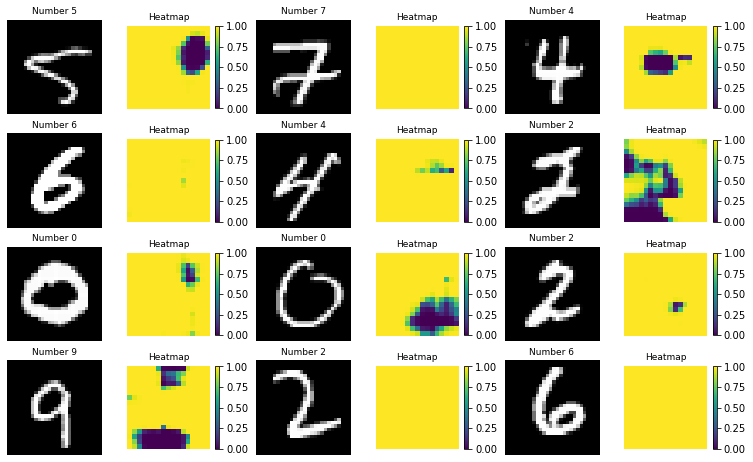

In [90]:
# Plotting activation of conv1 and conv2 for 10 images
dataloader = loaders['test']
direc = './drive/MyDrive/Semester_7/Advanced_Signal_Processing/A2_CNN/CNN_pics/'
prefix = direc + 'occ_'

with torch.no_grad():
    for X, y in dataloader:
        figure = plt.figure(figsize=(13, 8))
        cols, rows = 6, 4
        for i in range(1, cols * rows + 1, 2):
            image = X[i:i+1]
            label = y[i]
            heatmap = occlusion(model, image, label, occ_size=11)
            
            figure.add_subplot(rows, cols, i)
            plt.title('Number {}'.format(label), fontsize=9)
            plt.axis("off")
            plt.imshow(image.squeeze(), cmap='gray')
            
            figure.add_subplot(rows, cols, i+1)
            plt.title('Heatmap', fontsize=9)
            plt.axis("off")
            # vmin = 0 if torch.min(heatmap)<0.7 else 0.7
            plt.imshow(heatmap.squeeze(), vmin=0, vmax=1)
            plt.colorbar(shrink=0.87)
        plt.savefig(prefix + 'heatmap.png',bbox_inches='tight')
        plt.show()

# Adverserial Attacks

In [86]:
# Putting the model in eval mode
model.eval()

CNN(
  (conv1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
  )
  (conv2): Sequential(
    (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
  )
  (mp): Sequential(
    (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=1568, out_features=500, bias=True)
    (2): ReLU()
    (3): Linear(in_features=500, out_features=10, bias=True)
  )
)

## Non-Targeted Attack

In [93]:
def getNonTargetedAdverserialImage(model, target, stepsize=1e-3, max_iter=100, mu=0.5, threshold=1.0):
    '''
    Function to generate the adverserial image for a target starting from Gaussian noise image.
    We perform gradient ascent on the target logit by modifying input. We do not vary the model parameters.
    Arguments:
    model           The model that we will use
    target          Target class
    stepsize        Stepsize to use in the gradient ascent  [default: 1e-3]
    max_iter        Maximum number of GA iterations we want to run  [default: 100]
    mu              Mean of the initial Gaussian distribution       [default: 0.5]
    threshold       Threshold on class probability for stopping condition

    Return:
    Dict containing the cost transition, adverserial image and number of iterations
    '''

    # Creating a random gaussian matrix with mean 0.5
    # 0.5 is the midpoint as the training and test data are normalised
    X = mu + torch.randn(1, 1, 28, 28)
    X.requires_grad_(True)

    # Counter to keep track of number of iterations and list to store transition of costs
    count = 0
    costs = []

    # Running a do while loop
    while True:

        # Incrementing counter to keep track of number of iterations
        count += 1

        # Passing input through the model
        temp = model.forward(X)

        # Defining the cost that we will do the gradient ascent on
        # Logit corresponding to the target class
        cost = temp['values']['logits'][0, target]
        costs.append(cost.item())

        # Backpropagation
        cost.backward()

        # Update of input
        X.data = X.data + stepsize*X.grad

        # Zeroing out the gradient as PyTorch accumulates gradients
        X.grad.data.zero_()

        # Checking condition for continuing gradient ascent
        # If probability of target class for X reaches threshold or if we have done max_iter iterations, we stop
        if temp['values']['fc'][0, target] >= threshold or count == max_iter:
            break
    
    return {
        'adv_image': X,
        'cost': cost.item(),
        'cost_list': costs,
        'num_iter': count
    }


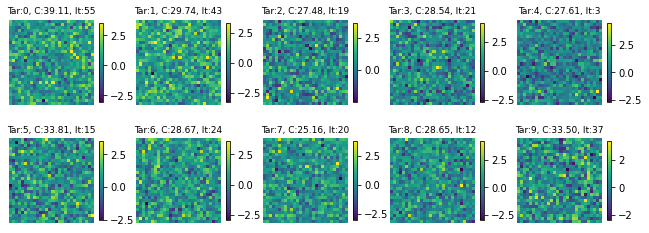

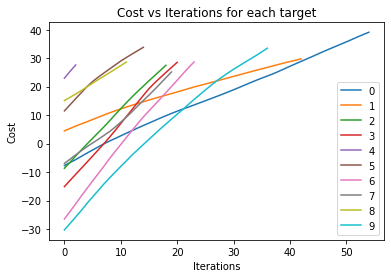

In [97]:
# Plotting the adverserial images for each of the classes
direc = './drive/MyDrive/Semester_7/Advanced_Signal_Processing/A2_CNN/CNN_pics/'
prefix = direc + 'non_tar_adv_'
costs = []
figure = plt.figure(figsize=(11, 4))
cols, rows = 5, 2
for i in range(1, cols * rows + 1):
    temp = getNonTargetedAdverserialImage(model, i-1, stepsize=1e-2, max_iter=1000)
    costs.append(temp['cost_list'])
    img = temp['adv_image'].detach().numpy()
    figure.add_subplot(rows, cols, i)
    plt.title('Tar:{0}, C:{1:.2f}, It:{2}'.format(i-1, temp['cost'], temp['num_iter']), fontsize=9)
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="viridis")
    plt.colorbar(shrink=0.8)
plt.savefig(prefix + 'img.png',bbox_inches='tight')
plt.show()

# Plotting the costs
plt.figure()
for i in range(10):
    plt.plot(costs[i], label='{}'.format(i))
plt.xlabel('Iterations')
plt.ylabel('Cost')
plt.title('Cost vs Iterations for each target')
plt.legend()
plt.savefig(prefix + 'cost.png',bbox_inches='tight')
plt.show()

## Targeted Attack

In [99]:
def getTargetedAdverserialImage(model, src_img, X, target, stepsize=1e-3, beta=1e-4, max_iter=100, threshold=1.0):
    '''
    Function to generate the adverserial image for a target loooking similar to src_img starting from X
    We perform gradient ascent on the cost by updating input and keeping the model parameters as is.
    Arguments:
    model           The model that we will use
    src_img         The source image for MSE comparison
    X               The image on which we perform the gradient ascent
    target          Target class
    stepsize        Stepsize to use in the gradient ascent  [default: 1e-3]
    beta            Controls similarity to source image     [default: 1e-4]
    max_iter        Maximum number of GA iterations we want to run  [default: 100]
    threshold       Threshold on class probability for stopping condition   [default: 1.0]

    Return:
    Dict containing the cost, adverserial image and number of iterations used
    '''
    # MSE loss
    mseloss = nn.MSELoss()

    # Counter to keep track of number of iterations
    count = 0
    costs = []

    # Running a do while loop
    while True:
        # Incrementing counter to keep track of number of iterations
        count += 1

        # Passing input through the model
        temp = model.forward(X)

        # Defining the cost that we will do the gradient ascent on
        cost = temp['values']['logits'][0, target] - beta*mseloss(src_img, X)
        costs.append(cost.item())

        # Backpropagation
        cost.backward()

        # Update of input
        X.data = X.data + stepsize*X.grad

        # Zeroing out the gradient
        X.grad.data.zero_()

        # Checking condition for continuing gradient ascent
        # If probability of target class for X reaches threshold or if we have done max_iter iterations, we stop
        if temp['values']['fc'][0, target] >= threshold or count == max_iter:
            break
    
    return {
        'adv_image': X,
        'cost': cost.item(),
        'cost_list': costs,
        'num_iter': count
    }


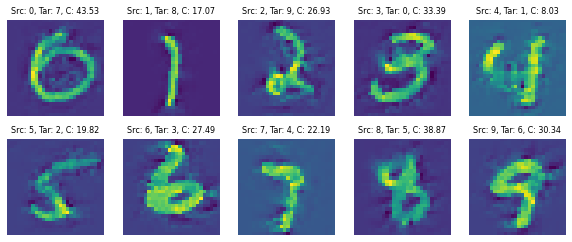

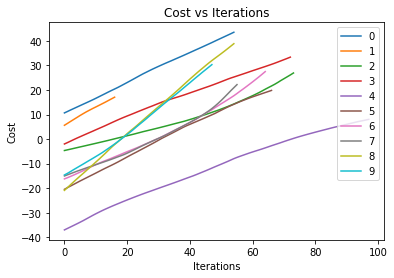

In [106]:
# Plotting the adverserial images for each of the classes
direc = './drive/MyDrive/Semester_7/Advanced_Signal_Processing/A2_CNN/CNN_pics/'
prefix = direc + 'tar_adv_'
costs = []

for X, y in loaders['test']:
    count = 0
    inds = [-1]*10
    y = y.numpy()
    for i in range(y.shape[0]):
        if inds[y[i]] == -1:
            inds[y[i]] = i
            count += 1
        if count == 10:
            break
    
    reports = []
    for i in range(10):
        src_img = X[inds[i]: inds[i]+1]
        img = src_img.detach().clone().requires_grad_(True)
        reports.append(getTargetedAdverserialImage(model, src_img, img, (i+6)%10, stepsize=0.005, beta=1e-4, max_iter=10000, threshold=0.97))

    figure = plt.figure(figsize=(10, 4))
    cols, rows = 5, 2
    for i in range(1, cols * rows + 1):
        costs.append(reports[i-1]['cost_list'])
        img = reports[i-1]['adv_image'].detach().numpy()
        figure.add_subplot(rows, cols, i)
        plt.title('Src: {2}, Tar: {0}, C: {1:.2f}'.format((i+6)%10, reports[i-1]['cost'], i-1), fontsize=8)
        plt.axis("off")
        plt.imshow(img.squeeze(), cmap="viridis")
        # plt.colorbar(shrink=0.8)
    plt.savefig(prefix + 'img.png',bbox_inches='tight')
    plt.show()

    # Plotting the costs
    plt.figure()
    for i in range(10):
        plt.plot(costs[i], label='{}'.format(i))
    plt.xlabel('Iterations')
    plt.ylabel('Cost')
    plt.title('Cost vs Iterations')
    plt.legend()
    plt.savefig(prefix + 'cost.png',bbox_inches='tight')
    plt.show()


## Adding Noise

In [108]:
def getNoisyAdverserialImage(model, X, target, stepsize=1e-3, max_iter=100, threshold=1.0):
    '''
    Function to generate the adverserial image for a target starting from X.
    We perform gradient ascent on the target logit by modifying noise added to X
    Arguments:
    model           The model that we will use
    X               Image from source class that we will start from
    target          Target class
    stepsize        Stepsize to use in the gradient ascent  [default: 1e-3]
    max_iter        Maximum number of GA iterations we want to run  [default: 100]
    threshold       Threshold on class probability to stop  [default: 1.0]
    Return:
    Dict containing the cost, adverserial image, number of iterations
    '''
    # Creating Noise tensor
    N = torch.zeros((1,1,28,28), requires_grad=True)

    # Counter to keep track of number of iterations
    count = 0
    costs = []

    # Running a do while loop
    while True:
        # Incrementing counter to keep track of number of iterations
        count += 1

        # Making Xn
        Xn = X + N

        # Passing input through the model
        temp = model.forward(Xn)

        # Defining the cost that we will do the gradient ascent on
        cost = temp['values']['logits'][0, target]
        costs.append(cost.item())

        # Backpropagation
        cost.backward()

        # Update of input
        N.data = N.data + stepsize*N.grad

        # Zeroing out the gradient
        N.grad.data.zero_()

        # Checking condition for continuing gradient ascent
        # If probability of target class for X reaches threshold or if we have done max_iter iterations, we stop
        if temp['values']['fc'][0,target] >= threshold or count == max_iter:
            break
    
    return {
        'adv_image': Xn,
        'noise': N,
        'cost': cost.item(),
        'cost_list': costs,
        'num_iter': count
    }


Iter 0: 39
Iter 1: 52
Iter 2: 30
Iter 3: 25
Iter 4: 39
Iter 5: 30
Iter 6: 38
Iter 7: 32
Iter 8: 1
Iter 9: 29


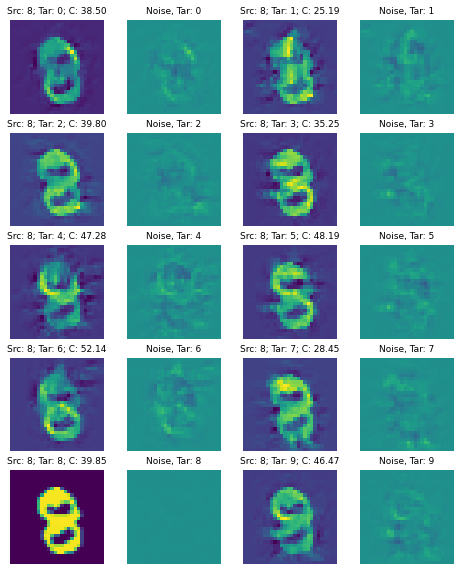

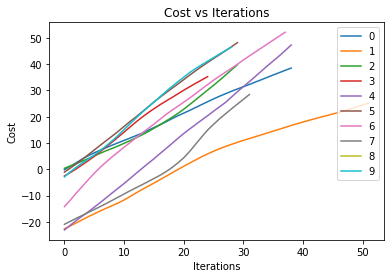

In [110]:
# Plotting the adverserial images for each of the classes
direc = './drive/MyDrive/Semester_7/Advanced_Signal_Processing/A2_CNN/CNN_pics/'
prefix = direc + 'noise_adv_'
costs = []

for X, y in loaders['test']:    
    reports = []
    src_img = X[0:1]
    src_img.requires_grad_(False)
    for i in range(10):
        reports.append(getNoisyAdverserialImage(model, src_img, i, stepsize=1e-2, max_iter=10000, threshold=1.0))

    figure = plt.figure(figsize=(8, 10))
    cols, rows = 4, 5
    for i in range(1, cols * rows + 1, 2):
        index = (i-1)//2
        costs.append(reports[index]['cost_list'])
        img = reports[index]['adv_image'].detach().numpy()
        noise = reports[index]['noise'].detach().numpy()
        print('Iter {}: {}'.format(index, reports[index]['num_iter']))

        figure.add_subplot(rows, cols, i)
        plt.title('Src: {2}; Tar: {0}; C: {1:.2f}'.format(index, reports[index]['cost'], y[0]), fontsize=9)
        plt.axis("off")
        plt.imshow(img.squeeze(), cmap="viridis")
            
        figure.add_subplot(rows, cols, i+1)
        # plt.title('Noise, Target: {}, Iter: {}'.format(index, reports[index]['num_iter']), fontsize=9)
        plt.title('Noise, Tar: {}'.format(index), fontsize=9)
        plt.axis("off")
        plt.imshow(noise.squeeze(), vmin=-2, vmax=2)
    plt.savefig(prefix + 'img.png', bbox_inches='tight')
    plt.show()

    # Plotting the costs
    plt.figure()
    for i in range(10):
        plt.plot(costs[i], label='{}'.format(i))
    plt.xlabel('Iterations')
    plt.ylabel('Cost')
    plt.title('Cost vs Iterations')
    plt.legend()
    plt.savefig(prefix + 'cost.png',bbox_inches='tight')
    plt.show()


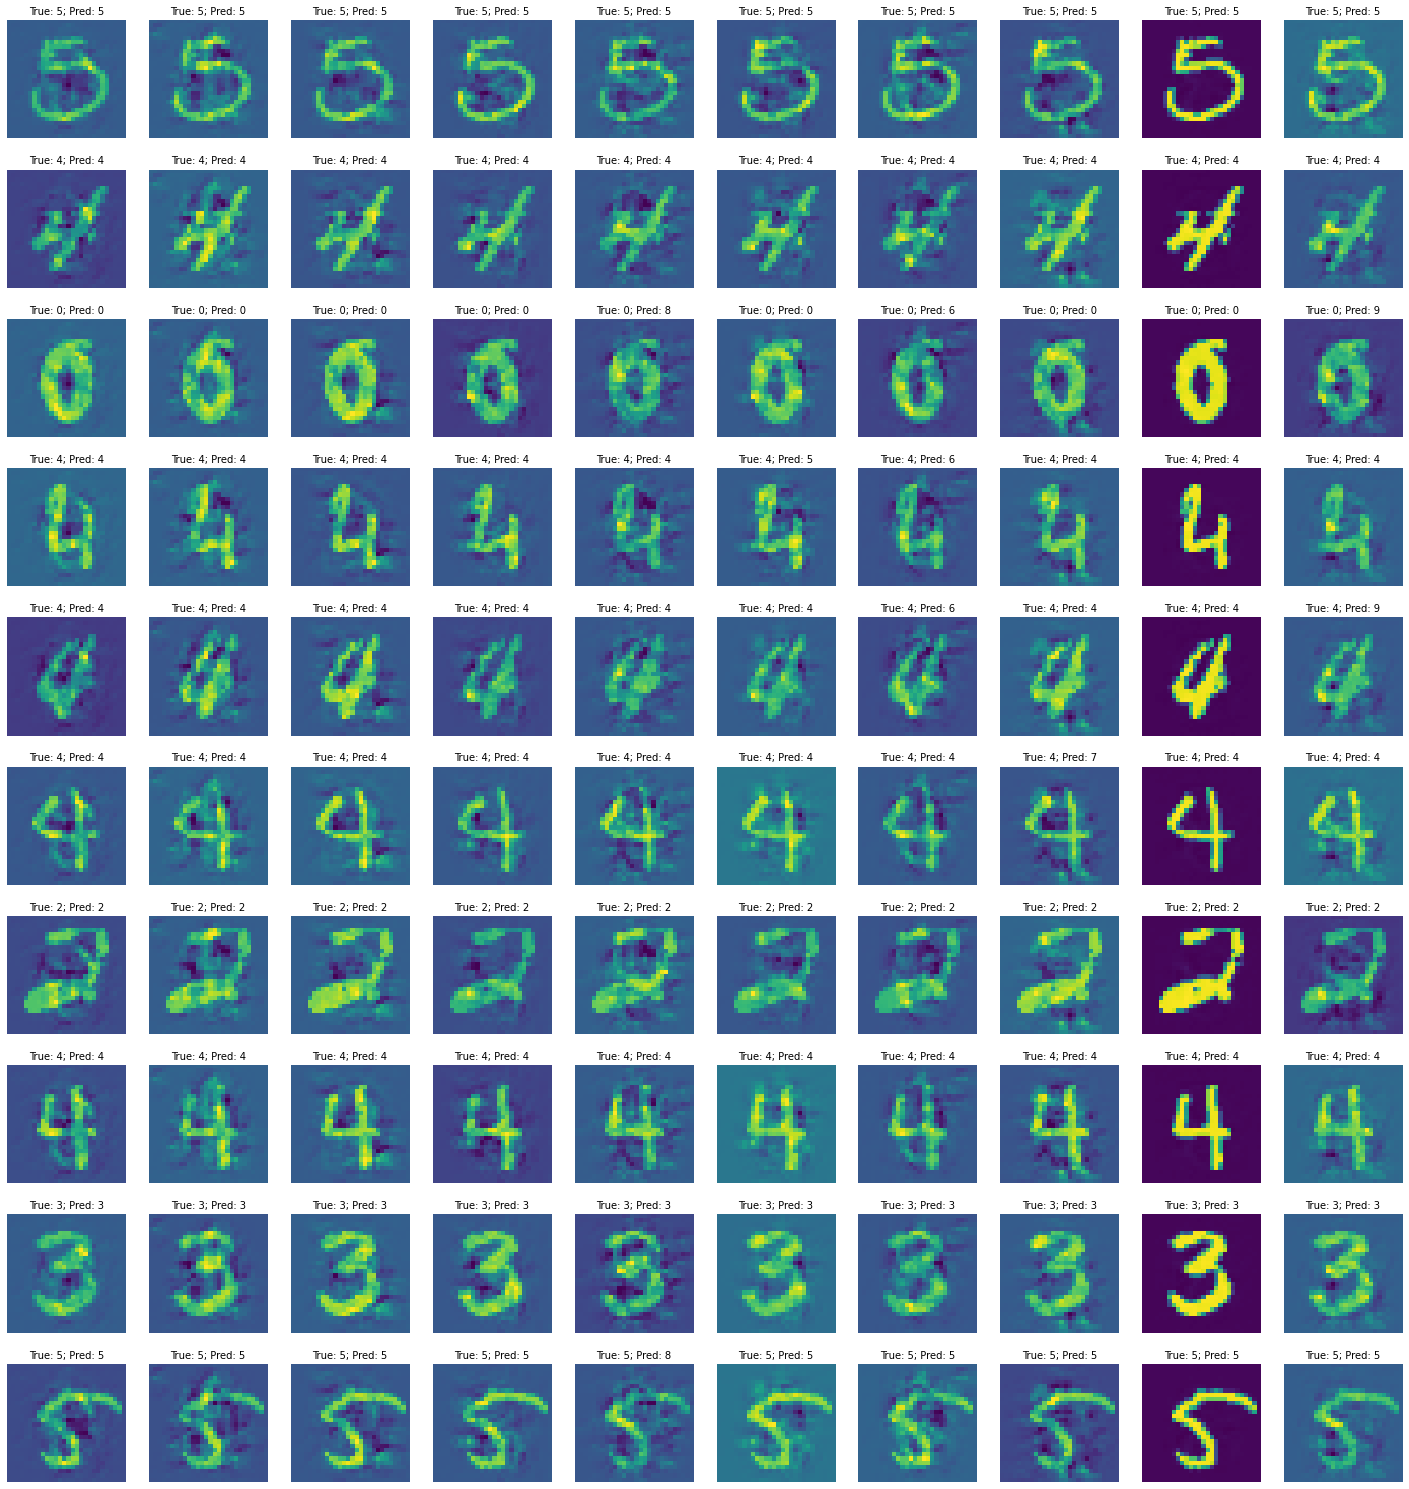

In [111]:
for X, y in loaders['test']:
    figure = plt.figure(figsize=(25, 27))
    cols, rows = 10, 10
    for s in range(10):
        for n in range(10):
            src_img = X[s: s+1]
            noise = reports[n]['noise']
            img = src_img + noise
            temp = model.forward(img)

            figure.add_subplot(10, 10, 10*(s)+n+1)
            plt.title('True: {0}; Pred: {1}'.format(y[s], temp['preds'][0]), fontsize=10)
            plt.axis("off")
            plt.imshow(img.detach().numpy().squeeze(), cmap="viridis")
    plt.savefig(prefix + 'cross.png',bbox_inches='tight')
    plt.show()

# Rough Work

In [145]:
for i in range(num_epochs):
    print(f"Epoch {i+7}\n-------------------------------")
    train_loop(loaders['train'], model, loss_fn, optimizer)
    test_loop(loaders['test'], model, loss_fn)
print("Done!")

Epoch 7
-------------------------------
loss: 1.474949  [    0/60000]
loss: 1.480190  [ 8000/60000]
loss: 1.480353  [16000/60000]
loss: 1.472052  [24000/60000]
loss: 1.467638  [32000/60000]
loss: 1.480543  [40000/60000]
loss: 1.479660  [48000/60000]
loss: 1.473717  [56000/60000]

Test Error: 
 Accuracy: 99.0%, Avg loss: 1.471794 

Epoch 8
-------------------------------
loss: 1.465144  [    0/60000]
loss: 1.466714  [ 8000/60000]
loss: 1.463425  [16000/60000]
loss: 1.461273  [24000/60000]
loss: 1.482066  [32000/60000]
loss: 1.477323  [40000/60000]
loss: 1.462142  [48000/60000]
loss: 1.474705  [56000/60000]

Test Error: 
 Accuracy: 98.9%, Avg loss: 1.472333 

Epoch 9
-------------------------------
loss: 1.468751  [    0/60000]
loss: 1.468023  [ 8000/60000]
loss: 1.473136  [16000/60000]
loss: 1.467224  [24000/60000]
loss: 1.482670  [32000/60000]
loss: 1.469671  [40000/60000]
loss: 1.467080  [48000/60000]
loss: 1.479101  [56000/60000]

Test Error: 
 Accuracy: 98.9%, Avg loss: 1.472732 

E

In [9]:
print(type(train_data[0]))
print(train_data[0][0].shape)
print(type(train_data[0][1]))

print(train_data.data[0].size())
print(train_data.targets[0])
print(test_data.data.size())
print(test_data.targets.size())

<class 'tuple'>
torch.Size([1, 28, 28])
<class 'int'>
torch.Size([28, 28])
tensor(5)
torch.Size([10000, 28, 28])
torch.Size([10000])


In [61]:
print(train_data.data[0])

tensor([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   3,  18,
          18,  18, 126, 136, 175,  26, 166, 255, 247, 127,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   

In [ ]:
count = 0
for X, y in loaders['test']:
    print(torch.max(X))
    print(torch.min(X))
    count +=1

print(count)

tensor(1.)
tensor(0.)
1


In [ ]:
print(model.state_dict()['conv2.0.weight'][0,0,:,:])
print(model.state_dict()['conv2.0.weight'][1,0,:,:])

tensor([[ 0.1682,  0.0352, -0.0727],
        [ 0.0445,  0.0273,  0.0332],
        [-0.0528,  0.0815,  0.0814]])
tensor([[-0.0973, -0.0522,  0.0827],
        [ 0.0806,  0.1013,  0.0621],
        [-0.0726, -0.0152, -0.0426]])
